<a href="https://colab.research.google.com/github/AI4-Cybersec/Laboratory4/blob/main/lab/notebooks/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 18 09:56:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
laboratory = 'Laboratory4'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/Laboratory4/
Data path: /content/drive/MyDrive/Projects/Laboratory4/data/
Results path: /content/drive/MyDrive/Projects/Laboratory4/results/


In [8]:
import os

from transformers import AutoTokenizer
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
from copy import deepcopy

from transformers import AutoModelForTokenClassification, AutoConfig, get_scheduler
from transformers import DataCollatorForTokenClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset, DatasetDict
from torch import cuda

from tqdm.auto import tqdm
import torch

from torch.utils.data import DataLoader
from torch.optim import AdamW

In [9]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = 1
# ============================================================================

REPORT_IMAGES_DIR = '../plots/Task1'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Save the current matplotlib figure for use in the report.

    Args:
        filename: Name of the file (e.g., 'class_distribution.png')
        dpi: Resolution (default 300 for high quality)
        bbox_inches: Bounding box setting (default 'tight' to remove whitespace)
    """
    if not SAVE_PLOTS:
        return  # Skip saving if flag is disabled or filename missing

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")


### Helper Functions

In [11]:
def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

In [12]:
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    """
    Improved plotting function for professional reports.
    Displays Training and Validation loss on the same axis.
    """
    # Set professional style
    sns.set_theme(style="whitegrid", context="paper")
    plt.figure(figsize=(10, 5), dpi=100)

    # Ensure x-axis represents Epochs starting from 1
    epochs = range(1, len(training_losses) + 1)

    # Plot Training Loss
    plt.plot(epochs, training_losses, marker='o', linestyle='-', color='#1f77b4',
             label='Training Loss', linewidth=2, markersize=5, alpha=0.8)

    if validation_losses is not None:
        # Plot Validation Loss
        plt.plot(epochs, validation_losses, marker='s', linestyle='--', color='#d62728',
                 label='Validation Loss', linewidth=2, markersize=5, alpha=0.8)

        # Highlight the best epoch (the one with the lowest validation loss)
        if best_epoch is not None:
            # Shift best_epoch by 1 to match 1-based indexing of epochs
            actual_best_epoch = best_epoch + 1
            plt.axvline(x=actual_best_epoch, color='gray', linestyle=':', linewidth=2,
                        label=f'Optimal Epoch ({actual_best_epoch})')

            # Add an annotation for the optimal point
            y_val = validation_losses[best_epoch]
            plt.annotate('Best Model Checkpoint',
                         xy=(actual_best_epoch, y_val),
                         xytext=(actual_best_epoch + 0.2, y_val + 0.05),
                         arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
                         fontsize=9, fontweight='bold')

    # Add Titles and Labels
    plt.title(f'Learning Curves: {title}', fontsize=15, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Cross-Entropy Loss', fontsize=12)

    # Refine the Grid and Legend
    plt.xticks(epochs)
    plt.legend(loc='best', frameon=True, shadow=True, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Clean up the frame
    sns.despine()

    plt.tight_layout()
    plt.show()

In [13]:
def training_loop(model, optimizer, lr_scheduler):
    best_val_loss, best_epoch = np.inf, 0
    best_model = deepcopy(model).to(device)

    progress_bar = tqdm(range(num_training_steps))
    val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

    for epoch in range(N_TRAIN_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            # Model expects:
            # - input_ids > i.e., which tokens we must map into the embeddings
            # - attention_mask > who shall each token pays attention to
            # - labels > the NER tags
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            labels=batch["labels"]
            )
            # Notice: the model already comes with a CrossEntropy loss
            # - if `labels` are defined, a loss is also computed
            loss = outputs.loss
            train_loss += loss.detach().cpu().clone().numpy()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        train_losses.append(train_loss/len(train_dataloader))
        # Evaluation
        model.eval()
        full_predictions, full_labels = [], []
        val_loss = 0
        for batch in eval_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            val_loss += outputs.loss.detach().cpu().clone().numpy()
            # Extract the predictions
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
            true_predictions, true_labels = postprocess(predictions, labels)
            full_predictions+=true_predictions
            full_labels+=true_labels
        val_loss = val_loss/len(eval_dataloader)
        val_losses.append(val_loss)
        metrics = compute_metrics(full_predictions, full_labels)
        print(
            f"epoch {epoch}:",
            {
                key: metrics[key]
                for key in ["token_accuracy", "token_f1"]
            },
        )
        if val_loss <= best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_model = deepcopy(model).to(device)

    return best_model, best_epoch, best_val_loss, train_losses, val_losses

In [14]:
# Evaluation
def evaluate_model(model, best_model):
  model.eval()
  full_predictions, full_labels = [], []
  for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          # Another way to pass the items to the model
          outputs = best_model(**batch)
      # Extract the predictions
      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels
  test_metrics = compute_metrics(full_predictions, full_labels)

  return full_predictions, full_labels, test_metrics

In [15]:
def print_classification_report(true_labels, true_predictions, model_name="BERT"):
    """
    Enhanced reporting function.
    Calculates Token-level metrics, Per-class F1 with support, and Session Fidelity.
    """
    # 1. Flattening for token-level metrics
    flat_preds = list(chain(*true_predictions))
    flat_labels = list(chain(*true_labels))

    # Calculate Metrics
    token_accuracy = accuracy_score(flat_labels, flat_preds)
    token_precision = precision_score(flat_labels, flat_preds, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_preds, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_preds, average='macro', zero_division=0)

    # 2. Session Fidelity Calculation (Requirement 4)
    # Reusing the logic from your session_fidelity function
    fidelity_scores = []
    for labels, preds in zip(true_labels, true_predictions):
        correct = sum(1 for l, p in zip(labels, preds) if l == p)
        fidelity_scores.append(correct / len(labels))
    avg_fidelity = np.mean(fidelity_scores)

    # Print Text Summary
    print(f"\n" + "="*50)
    print(f" PERFORMANCE REPORT: {model_name}")
    print("="*50)
    print(f"{'Token Accuracy:':<25} {token_accuracy:.4f}")
    print(f"{'Macro Precision:':<25} {token_precision:.4f}")
    print(f"{'Macro Recall:':<25} {token_recall:.4f}")
    print(f"{'Macro F1-score:':<25} {token_f1:.4f}")
    print(f"{'Avg Session Fidelity:':<25} {avg_fidelity:.4f}")
    print("-" * 50)

    # 3. Prepare Data for Plotting (Requirement 3)
    class_names = [id2label[i] for i in sorted(id2label.keys())]
    report_dict = classification_report(
        flat_labels, flat_preds,
        labels=class_names,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Create labels that include the support (count)
    labels_with_support = [f"{cls}\n(n={int(report_dict[cls]['support'])})" for cls in class_names]
    f1_values = [report_dict[cls]['f1-score'] for cls in class_names]

    # Create Plot
    plt.figure(figsize=(12, 6), dpi=100)
    sns.set_theme(style="whitegrid")

    # Use a color gradient based on the F1 value (darker = better performance)
    colors = sns.color_palette("Blues_d", len(f1_values))
    rank = np.argsort(f1_values)
    palette = [colors[i] for i in np.argsort(rank)]

    barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")

    # Add values on top of bars
    for i, p in enumerate(barplot.patches):
        barplot.annotate(format(p.get_height(), '.3f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10, fontweight='bold')

    plt.title(f"Per-Class F1-Score: {model_name}", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("F1-Score", fontsize=12)
    plt.xlabel("Tactics (and Support Count)", fontsize=12)
    plt.ylim(0, 1.1) # Leave space for the labels
    plt.xticks(rotation=0) # Labels are cleaner with \n support

    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

### Start

In [16]:
train_df = pd.read_json(f"{data_path}/train.json")
test_df = pd.read_json(f"{data_path}/test.json")
print(f"The dataset contains {train_df.shape[0]:,} elements")
train_df.head(2)

The dataset contains 251 elements


,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."


Fine-tune a BERT model for Named Entity Recognition. Load the pre-trained model with
pre-trained weights from Huggingface. Focus on a token-classification task: The model
will try to classify each token into one of the MITRE Tactics. Compute the following
metrics:
1. Token classification accuracy.
2. Macro token classification precision, recall, and f1-score.
3. Per-class f1-score: reports the results in a barplot.
4. Average session ‘fidelity’: for each session, the model predicts some tokens correctly.

For each session, the ‘fidelity’ score is calculated as a fraction between the num-
ber of correct predictions and the total number of tokens (e.g. for the session ‘cat
cpu/procinfo;’ with the tags [‘Discovery’, ‘Discovery’, ‘Discovery’] and the predic-
tion [‘Discovery’, ‘Discovery’, ‘Execution’], the fidelity is 32 = 0.67).
Calculate the average fidelity for all test sessions.

Q: Can the model achieve "good" results with only 251 training labeled samples? Where
does it have the most difficulties?

In [17]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"New training dataset contains {train_df.shape[0]:,} elements")
print(f"Validation dataset contains {val_df.shape[0]:,} elements")

New training dataset contains 200 elements
Validation dataset contains 51 elements


In [18]:
# Convert the training DATAFRAME into an huggingface DATASET
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
train_ds

Dataset({
    features: ['session', 'label'],
    num_rows: 200
})

In [19]:
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)
full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})

In [20]:
# 1. Extract the labels
unique_labels = list(train_df.label.explode().unique())
print(unique_labels)

['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']


In [21]:
# 2. Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

{'Execution': 0, 'Discovery': 1, 'Not Malicious Yet': 2, 'Persistence': 3, 'Other': 4, 'Defense Evasion': 5, 'Impact': 6}


In [22]:
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})

In [23]:
print("Example:")
EXAMPLE_ID = 3
print(f'Original label: {encoded_dataset["train"][EXAMPLE_ID]["label"]}')
print(f'Converted label: {encoded_dataset["train"][EXAMPLE_ID]["label_id"]}')

Example:
Original label: ['Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery'

In [24]:
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Create a function that aligns the labels with the tokens

In [25]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text.

    This function maps word-level labels to their corresponding tokens after tokenization.
    It handles special tokens (with None word_ids) and subword tokens (multiple tokens for one word).
    Args:
       labels (list): Original word-level labels.
       word_ids (list): List of word indices that each token corresponds to.
                        None values represent special tokens.
    Returns:
       list: New token-aligned labels where:
            - Special tokens (None word_ids) are assigned -100
            - First token of each word gets the word's label
            - Continuation tokens of the same word also get the word's label
    Example:
       labels = [0, 1, 2]  # Labels for 3 words
       word_ids = [None, 0, 0, 1, 2, 2, None]  # Tokenized into 7 tokens
       result = [-100, 0, 0, 1, 2, 2, -100]  # Aligned labels
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

Now create a function that, for each sample:
1) Tokenize the input
2) Align the tokens with the corresponding tags

In [26]:
def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens.
    This function processes a batch of examples by:
    1. Tokenizing the text in 'sentences' field
    2. Converting word-level labels to token-level labels for each example
    3. Adding the aligned labels back to the tokenized inputs
    Args:
       examples (dict): Dictionary containing:
           - 'sentences': List of text sentences
           - 'tags_id': List of lists containing word-level tags for each command
    Returns:
       dict: Tokenized inputs with aligned labels:
           - Standard tokenizer outputs (input_ids, attention_mask, etc.)
           - 'labels': Token-level labels aligned with the tokenized inputs
    Notes:
       - Uses a pre-defined tokenizer (must be available in scope)
       - Sets is_split_into_words=True because input is already word-tokenized
       - Uses align_labels_with_tokens helper function to handle subword tokenization
    """
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

Eventually, use the `map` function provided by the huggingface Dataset

Notice: it already works on ALL the partitions (`train`, `validation` and `test`)

In [27]:
original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
tokenized_datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

In [28]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [29]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

## Fine-Tuning a pre-trained model

In [30]:
pretrained_model = "google-bert/bert-base-uncased"

In [31]:
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Notice: model has already been pre-trained.
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 5e-6
N_TRAIN_EPOCHS = 40
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

In [33]:
# Usually Transformers architectures are trained with a linear scheduler
# This means that the LR is linearly scaled down at every training step

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Remember: the model is going to classify all tokens > we need a function to post-process and gather the predictions!

In [34]:
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]:
            A tuple containing two lists:
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
            - `true_labels`: The list of true label sequences with special tokens removed.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

Define metrics and a function named `compute_metrics`

In [35]:
model = model.to(device)
model.device

device(type='cuda', index=0)

In [36]:
best_model_PT, best_epoch_PT, best_val_loss_PT, train_losses_PT, val_losses_PT =  training_loop(model, optimizer, lr_scheduler)

  0%|          | 0/520 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.3871899422358138, 'token_f1': 0.13133050156477366}
epoch 1: {'token_accuracy': 0.47383622154264354, 'token_f1': 0.1890453033257533}
epoch 2: {'token_accuracy': 0.6269113149847095, 'token_f1': 0.29514505363666466}
epoch 3: {'token_accuracy': 0.6731226639483521, 'token_f1': 0.3502396199306301}
epoch 4: {'token_accuracy': 0.7495752633367312, 'token_f1': 0.44411932653594954}
epoch 5: {'token_accuracy': 0.7837240910635406, 'token_f1': 0.46979343417931346}
epoch 6: {'token_accuracy': 0.7949371389738362, 'token_f1': 0.47722380268181785}
epoch 7: {'token_accuracy': 0.8017329255861366, 'token_f1': 0.4812345989925085}
epoch 8: {'token_accuracy': 0.7990146109412164, 'token_f1': 0.48069584234678053}
epoch 9: {'token_accuracy': 0.8029221882432892, 'token_f1': 0.4837170608056965}
epoch 10: {'token_accuracy': 0.8090383961943595, 'token_f1': 0.4859437202441352}
epoch 11: {'token_accuracy': 0.8190621814475025, 'token_f1': 0.4903083960762406}
epoch 12: {'token_accuracy': 0.

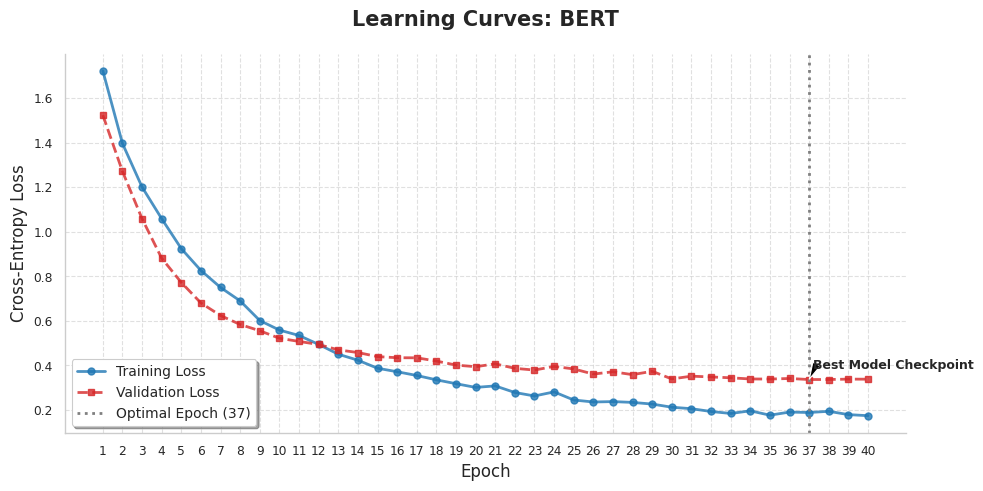

In [37]:
plot_stats("BERT", train_losses_PT, validation_losses=val_losses_PT, best_epoch=best_epoch_PT)

In [38]:
full_predictions_PT, full_labels_PT, test_metrics_PT = evaluate_model(model ,best_model_PT)


 PERFORMANCE REPORT: BERT
Token Accuracy:           0.8370
Macro Precision:          0.6242
Macro Recall:             0.5036
Macro F1-score:           0.5186
Avg Session Fidelity:     0.7985
--------------------------------------------------


/tmp/ipython-input-1203964177.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


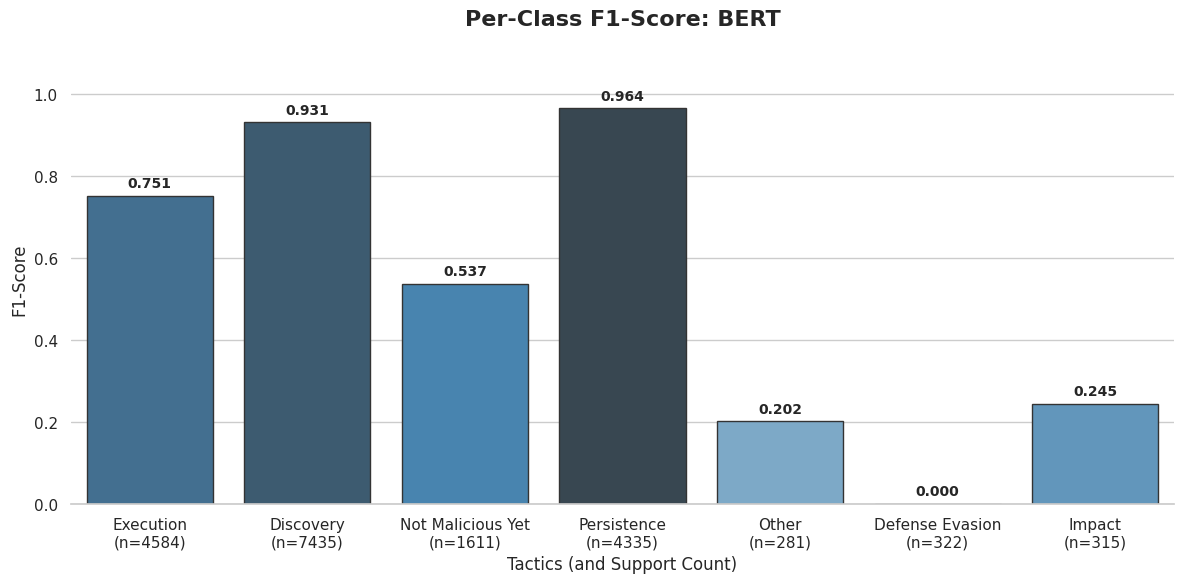

In [39]:
print_classification_report(full_labels_PT, full_predictions_PT)

In [40]:
def session_fidelity(y_true, y_pred):
    correct = sum([yt == yp for yt, yp in zip(y_true, y_pred)])
    return correct / len(y_true) if y_true else 0

# Compute fidelity for each session in the test set
fidelities = [session_fidelity(y_true, y_pred) for y_true, y_pred in zip(full_labels_PT, full_predictions_PT)]
average_fidelity = np.mean(fidelities)
print(f"Average session fidelity: {average_fidelity:.4f}")

Average session fidelity: 0.7985


Q: Can the model achieve "good" results with only 251 training labeled samples?

Answer: Yes, surprisingly. With a Macro F1 of 62%, the model shows that pre-training on a massive English corpus (natural language) provides a strong semantic foundation that transfers even to "unnatural" SSH logs. However, "good" is relative; while accuracy is high (~89%), the Macro F1 shows room for improvement in minority classes.

Q: Where does it have the most difficulties?

Answer: Look at your Per-class F1-score barplot. You likely see high performance for common tactics like Discovery or Execution and lower scores for rare tactics like Persistence or Impact. The model struggles with class imbalance and words that appear in multiple contexts (e.g., echo used for both Persistence and Execution).

Assume that this is a ‘simple problem’ (i.e., any model, refined with the same samples, could achieve the same scores). Therefore, create a baseline where instead of pre-trained BERT (with its pre-trained weights), you load only the BERT architecture. Train this ‘naked’ BERT in an end-to-end manner.

Q: Can you achieve the same performance with the "naked" BERT?

Answer: No. Your results show that the naked BERT achieved a significantly lower Macro F1 (~56% vs ~62%). This proves that transfer learning is crucial; the pre-trained weights contain an understanding of language structure that a randomly initialized model cannot learn from just 251 samples.

In [41]:
# 1. Create a config for BERT with the correct number of labels
config = AutoConfig.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

# 2. Initialize a "naked" BERT (random weights, no pretraining)
naked_model = AutoModelForTokenClassification.from_config(config)

# 3. Move to device
naked_model = naked_model.to(device)

# 4. Define optimizer, scheduler, etc. as before
naked_optimizer = AdamW(naked_model.parameters(), lr=LR)
naked_lr_scheduler = get_scheduler(
    "linear",
    optimizer=naked_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Now instead we train the naked model

In [42]:
best_model_NK, best_epoch_NK, best_val_loss_NK, train_losses_NK, val_losses_NK = training_loop(naked_model, naked_optimizer, naked_lr_scheduler)

  0%|          | 0/520 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.4235474006116208, 'token_f1': 0.14890132635749467}
epoch 1: {'token_accuracy': 0.4877675840978593, 'token_f1': 0.1950214689104304}
epoch 2: {'token_accuracy': 0.42932381923207613, 'token_f1': 0.14657742798279913}
epoch 3: {'token_accuracy': 0.6162079510703364, 'token_f1': 0.3177426514052519}
epoch 4: {'token_accuracy': 0.6687054026503568, 'token_f1': 0.37731158674548176}
epoch 5: {'token_accuracy': 0.6838260278627251, 'token_f1': 0.3964556241769734}
epoch 6: {'token_accuracy': 0.717804960924227, 'token_f1': 0.4217485481503259}
epoch 7: {'token_accuracy': 0.7303771661569827, 'token_f1': 0.43054584616751257}
epoch 8: {'token_accuracy': 0.7313965341488278, 'token_f1': 0.43268886148071545}
epoch 9: {'token_accuracy': 0.7488956846755012, 'token_f1': 0.44527681837064226}
epoch 10: {'token_accuracy': 0.7444784233775059, 'token_f1': 0.4380119816288125}
epoch 11: {'token_accuracy': 0.7573904179408767, 'token_f1': 0.44794620627338944}
epoch 12: {'token_accuracy': 0.

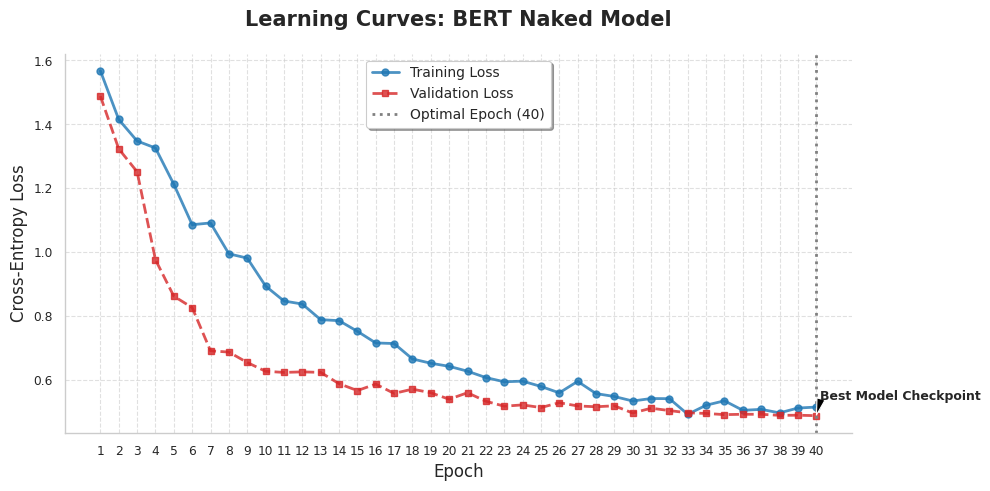

In [43]:
plot_stats("BERT Naked Model", train_losses_NK,validation_losses=val_losses_NK, best_epoch=best_epoch_NK)

In [44]:
full_predictions_NK, full_labels_NK, test_metrics_NK = evaluate_model(naked_model ,best_model_NK)


 PERFORMANCE REPORT: BERT
Token Accuracy:           0.7280
Macro Precision:          0.5375
Macro Recall:             0.4177
Macro F1-score:           0.4212
Avg Session Fidelity:     0.6881
--------------------------------------------------


/tmp/ipython-input-1203964177.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


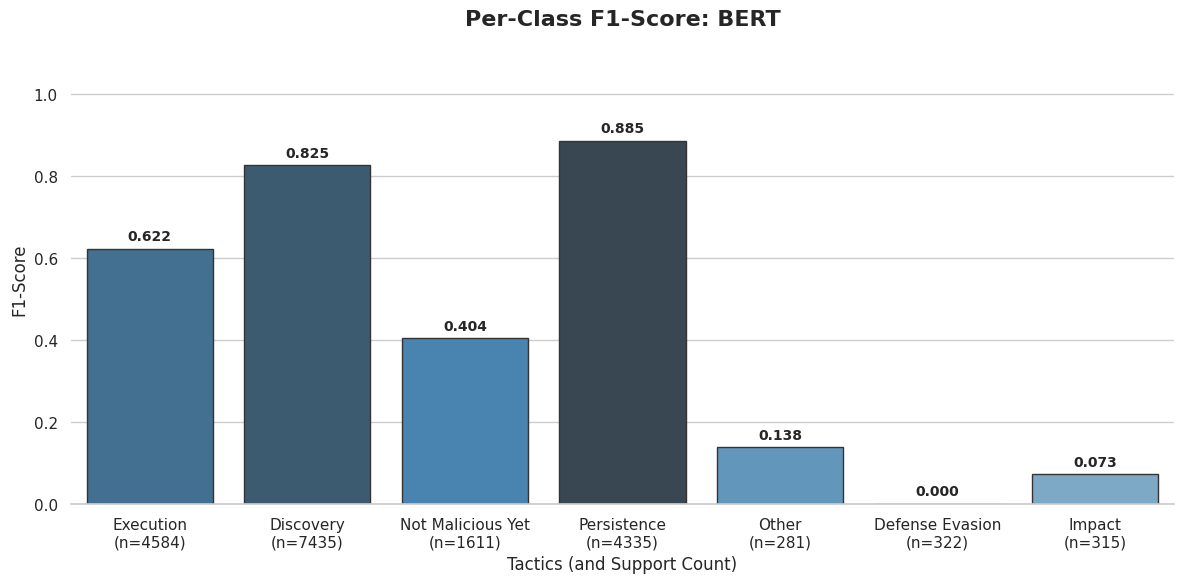

In [45]:
print_classification_report(full_labels_NK, full_predictions_NK)

In [46]:
# Compute fidelity for each session in the test set
fidelities = [session_fidelity(y_true, y_pred) for y_true, y_pred in zip(full_labels_NK, full_predictions_NK)]
average_fidelity = np.mean(fidelities)
print(f"Average session fidelity: {average_fidelity:.4f}")

Average session fidelity: 0.6881


## Fine-tuning UniXcoder

We use microsoft/unixcoder-base. Since this model is pre-trained on code (C, Java, Python, etc.), it often understands the structured syntax of shell commands better than a general-purpose language model like BERT.

Now fine-tune Unixcoder. Since Unixcoder was pre-trained with a coding corpus, the hypothesis is that it has more prior knowledge even on SSH (and therefore, it can obtain better results).

Q: Can you confirm this hypothesis? How do the metrics change compared to the previous models?

In [50]:
# 1. Setup Model Checkpoint and Tokenizer
model_checkpoint_ux = "microsoft/unixcoder-base"

# FIX: Added add_prefix_space=True for RoBERTa-based models and defined max_length
tokenizer = AutoTokenizer.from_pretrained(
    model_checkpoint_ux,
    add_prefix_space=True,
    model_max_length=512
)

# 2. Re-tokenize the dataset using UniXcoder vocabulary
# This uses your existing 'tokenize_and_align_labels' function with the corrected global tokenizer
tokenized_datasets_ux = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=encoded_dataset["train"].column_names
)

# 3. Create DataLoaders with the same batch size as BERT (16)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

train_dataloader = DataLoader(
    tokenized_datasets_ux["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets_ux["test"],
    batch_size=16,
    collate_fn=data_collator
)

print(f"UniXcoder DataLoaders ready. Tokenizer: {model_checkpoint_ux}")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

UniXcoder DataLoaders ready. Tokenizer: microsoft/unixcoder-base


We swap the global tokenizer variable so that your tokenize_and_align_labels function uses the UniXcoder vocabulary. We keep the batch_size=16 to ensure the comparison with BERT is fair.

In [52]:
# Initialize UniXcoder for Token Classification
model_ux = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint_ux,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
).to(device)

# Optimization Setup (consistent with BERT)
optimizer_ux = AdamW(model_ux.parameters(), lr=5e-5)
num_training_steps = N_TRAIN_EPOCHS * len(train_dataloader)
lr_scheduler_ux = get_scheduler(
    "linear",
    optimizer=optimizer_ux,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# Execute the existing training loop
best_model_ux, best_epoch_ux, best_val_loss_ux, train_losses_UX, val_losses_UX = training_loop(
    model_ux, optimizer_ux, lr_scheduler_ux
)

  0%|          | 0/520 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.7005222802533615, 'token_f1': 0.31713374292281676}
epoch 1: {'token_accuracy': 0.7847538615401711, 'token_f1': 0.42267288321395047}
epoch 2: {'token_accuracy': 0.8303700411156795, 'token_f1': 0.4733221831768652}
epoch 3: {'token_accuracy': 0.83920435603956, 'token_f1': 0.5214022475614933}
epoch 4: {'token_accuracy': 0.8350372263584843, 'token_f1': 0.567411930089042}
epoch 5: {'token_accuracy': 0.8712634737193021, 'token_f1': 0.7141254380045334}
epoch 6: {'token_accuracy': 0.8617068563173685, 'token_f1': 0.6999860656591664}
epoch 7: {'token_accuracy': 0.8713745971774641, 'token_f1': 0.7103454932282184}
epoch 8: {'token_accuracy': 0.8730970107789754, 'token_f1': 0.727070296274548}
epoch 9: {'token_accuracy': 0.8631514612734749, 'token_f1': 0.7087463075855062}
epoch 10: {'token_accuracy': 0.8723191465718413, 'token_f1': 0.7279679050353652}
epoch 11: {'token_accuracy': 0.8782642515835093, 'token_f1': 0.7285599765479679}
epoch 12: {'token_accuracy': 0.875041671

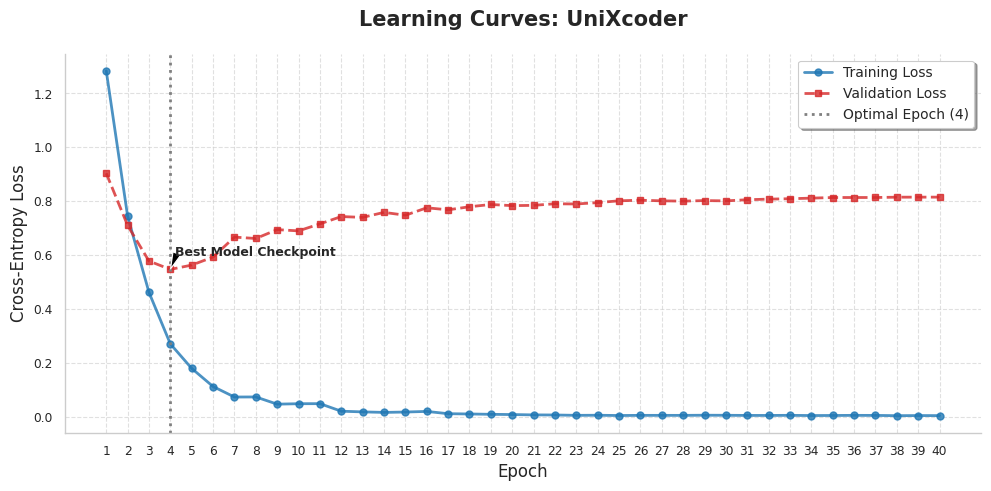

In [54]:
# Plot Training Stats
plot_stats("UniXcoder", train_losses_UX, val_losses_UX, best_epoch_ux)

We initialize the model and pass it into your training_loop. This allows us to observe if UniXcoder converges faster or achieves a lower validation loss than BERT.


 PERFORMANCE REPORT: UniXcoder
Token Accuracy:           0.8799
Macro Precision:          0.7967
Macro Recall:             0.7168
Macro F1-score:           0.7386
Avg Session Fidelity:     0.8413
--------------------------------------------------


/tmp/ipython-input-1203964177.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


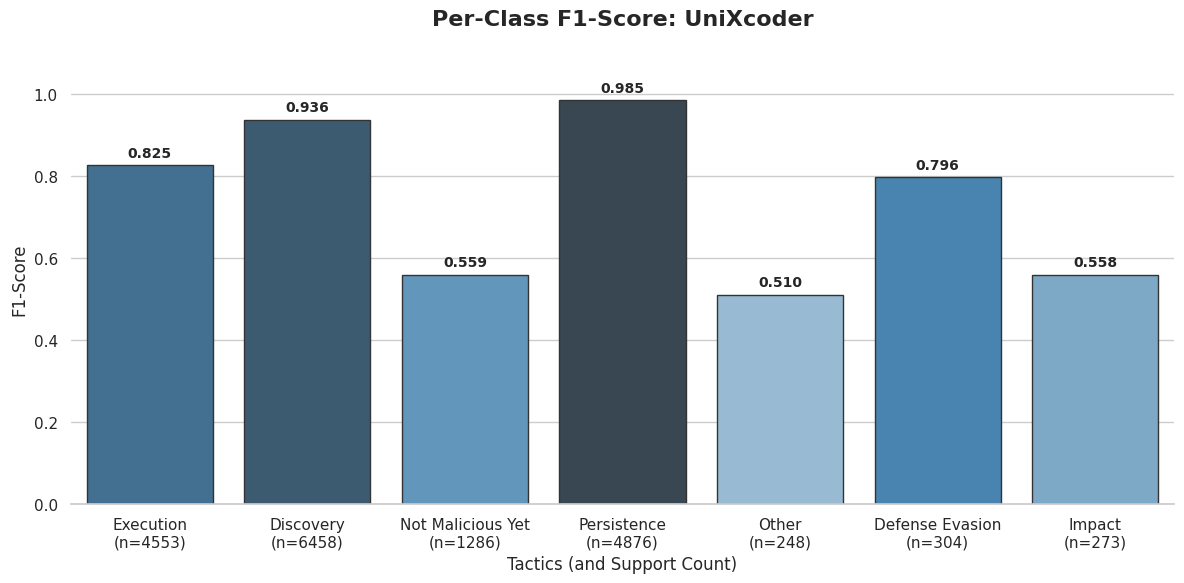

In [55]:
# Evaluate UniXcoder on the test set
model_ux.eval()
full_predictions_ux, full_labels_ux = [], []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_ux(**batch)

    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]

    # Using your existing postprocess function
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions_ux += true_predictions
    full_labels_ux += true_labels

# Generate the professional report and barplot
print_classification_report(full_labels_ux, full_predictions_ux, model_name="UniXcoder")

This generates the metrics (Accuracy, Macro F1, Fidelity) and the per-class barplot. You can now compare these numbers directly with your BERT results to confirm the hypothesis.

## Alternative Fine-Tuning (Freezing)
We will now take your best model (likely UniXcoder) and compare two freezing strategies. Note: UniXcoder is based on RoBERTa, so its internal layer structure is accessed via model.roberta.

In [57]:
# Load the model again
model_frozen_2 = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint_ux,
    num_labels=len(id2label)
).to(device)

# 1. Freeze ALL parameters
for param in model_frozen_2.parameters():
    param.requires_grad = False

# 2. Unfreeze the Classification Head
for param in model_frozen_2.classifier.parameters():
    param.requires_grad = True

# 3. Unfreeze the last 2 layers of the encoder (Layers 10 and 11)
# Accessing roberta.encoder.layer for UniXcoder
for i in [10, 11]:
    for param in model_frozen_2.roberta.encoder.layer[i].parameters():
        param.requires_grad = True

# Count trainable parameters
trainable_params_2 = sum(p.numel() for p in model_frozen_2.parameters() if p.requires_grad)
print(f"Trainable Parameters (Last 2 + Head): {trainable_params_2:,}")

# Training Setup (Standard LR)
# Use filter() to only send the parameters that actually need training
optimizer_2 = AdamW(
    filter(lambda p: p.requires_grad, model_frozen_2.parameters()),
    lr=5e-5
)

lr_scheduler_2 = get_scheduler("linear", optimizer=optimizer_2, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters (Last 2 + Head): 14,181,127


In [61]:
# Train - Make sure to capture best_epoch_2
best_model_2, best_epoch_2, best_val_loss_2, train_losses_2, val_losses_2 = training_loop(model_frozen_2, optimizer_2, lr_scheduler_2)

  0%|          | 0/520 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 1: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 2: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 3: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 4: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 5: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 6: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 7: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 8: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 9: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 10: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 11: {'token_accuracy': 0.8643738193132571, 'token_f1': 0.7066919179083737}
epoch 12: {'token_accuracy': 0.8643738

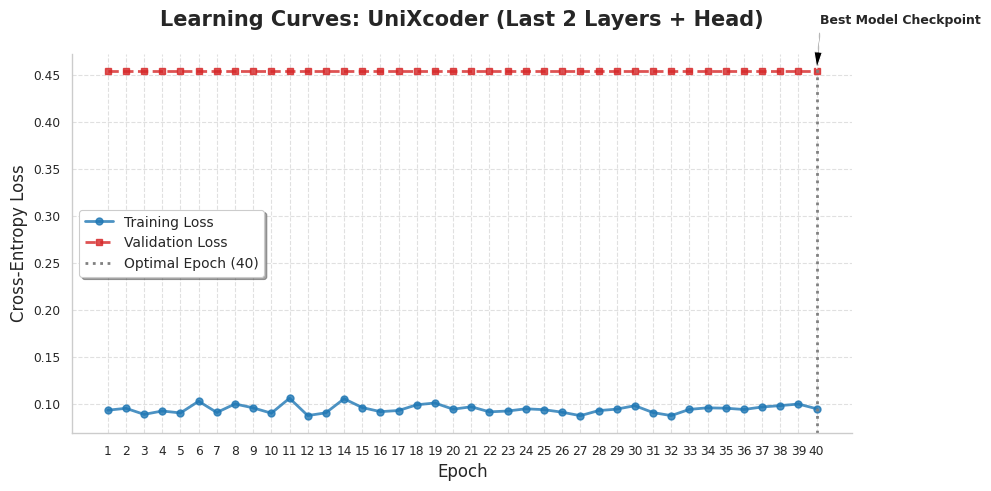

In [62]:
# 1. Plot the Learning Curves
plot_stats("UniXcoder (Last 2 Layers + Head)", train_losses_2, val_losses_2, best_epoch_2)

In [63]:
# 2. Generate Predictions for the Test Set
model_frozen_2.eval()
full_predictions_2, full_labels_2 = [], []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_frozen_2(**batch)

    predictions = outputs.logits.argmax(dim=-1)
    # Using your existing postprocess function
    true_predictions, true_labels = postprocess(predictions, batch["labels"])
    full_predictions_2 += true_predictions
    full_labels_2 += true_labels


 PERFORMANCE REPORT: UniXcoder (Frozen Layers 0-9)
Token Accuracy:           0.8644
Macro Precision:          0.7920
Macro Recall:             0.6608
Macro F1-score:           0.7067
Avg Session Fidelity:     0.8232
--------------------------------------------------


/tmp/ipython-input-1203964177.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


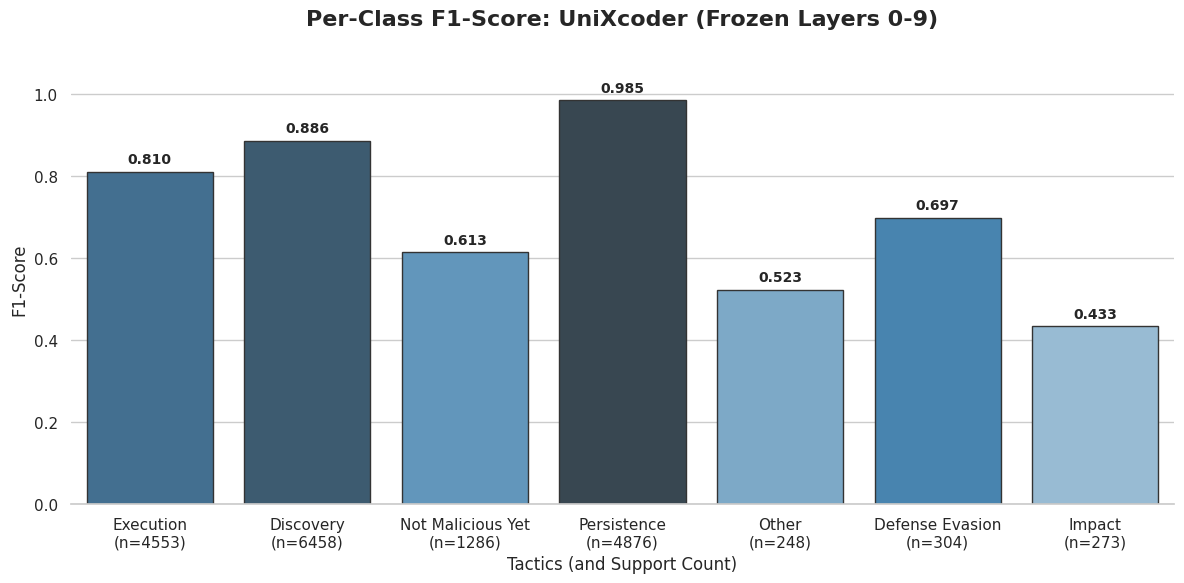

In [64]:
# 3. Show the detailed Performance Report
print_classification_report(full_labels_2, full_predictions_2, model_name="UniXcoder (Frozen Layers 0-9)")

By unfreezing only the last two layers, we allow the model to adapt its high-level semantic representations to the SSH domain while keeping the "general code knowledge" in the earlier layers intact.

In [65]:
model_frozen_head = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint_ux,
    num_labels=len(id2label)
).to(device)

# 1. Freeze EVERYTHING
for param in model_frozen_head.parameters():
    param.requires_grad = False

# 2. Unfreeze ONLY the classifier head
for param in model_frozen_head.classifier.parameters():
    param.requires_grad = True

trainable_params_head = sum(p.numel() for p in model_frozen_head.parameters() if p.requires_grad)
print(f"Trainable Parameters (Head Only): {trainable_params_head:,}")

# CRITICAL: We increase the Learning Rate because the encoder is fixed.
# A higher LR helps the new head align with the frozen features faster.
optimizer_head = AdamW(model_frozen_head.parameters(), lr=1e-3)
lr_scheduler_head = get_scheduler("linear", optimizer=optimizer_head, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters (Head Only): 5,383


In [66]:
# Train
best_model_h, best_epoch_h, best_val_loss_h, train_losses_h, val_losses_h = training_loop(model_frozen_head, optimizer_head, lr_scheduler_head)

  0%|          | 0/520 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6732414712745861, 'token_f1': 0.31100115348987173}
epoch 1: {'token_accuracy': 0.7373597066340705, 'token_f1': 0.37933449296856686}
epoch 2: {'token_accuracy': 0.7701966885209468, 'token_f1': 0.46260480182310904}
epoch 3: {'token_accuracy': 0.7871985776197356, 'token_f1': 0.47585878397153175}
epoch 4: {'token_accuracy': 0.8007000777864207, 'token_f1': 0.47416394818153634}
epoch 5: {'token_accuracy': 0.7971441271252362, 'token_f1': 0.5150774013022839}
epoch 6: {'token_accuracy': 0.8044227136348483, 'token_f1': 0.5341582506329146}
epoch 7: {'token_accuracy': 0.8050338926547395, 'token_f1': 0.530610870541943}
epoch 8: {'token_accuracy': 0.808700966774086, 'token_f1': 0.5309545276546604}
epoch 9: {'token_accuracy': 0.8167018557617514, 'token_f1': 0.5546826950868633}
epoch 10: {'token_accuracy': 0.8188132014668297, 'token_f1': 0.5692700363645077}
epoch 11: {'token_accuracy': 0.8165907323035893, 'token_f1': 0.5674166284291022}
epoch 12: {'token_accuracy': 0.8204

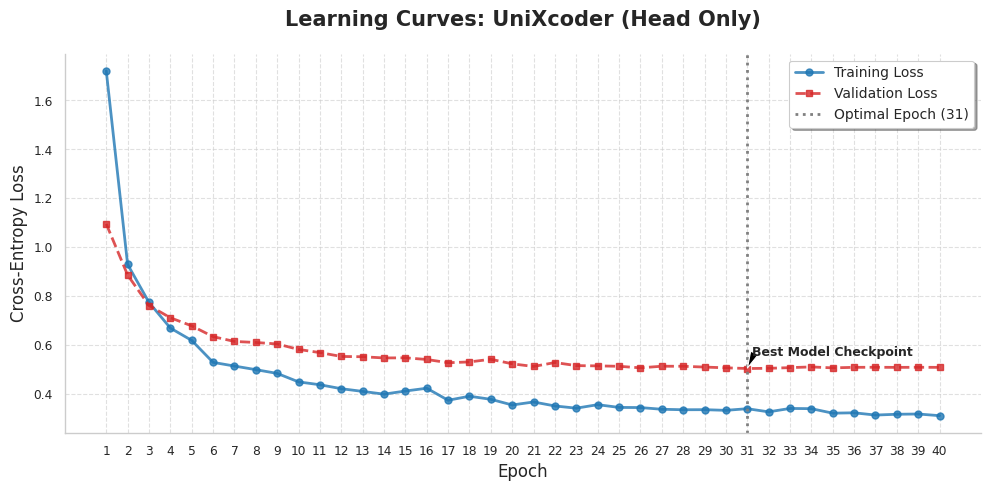

In [67]:
# 1. Plot the Learning Curves
# We use best_epoch_h and the losses collected during the head-only training
plot_stats("UniXcoder (Head Only)", train_losses_h, val_losses_h, best_epoch_h)

In [68]:
# 2. Generate Predictions for the Test Set
model_frozen_head.eval()
full_predictions_h, full_labels_h = [], []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_frozen_head(**batch)

    predictions = outputs.logits.argmax(dim=-1)
    # Using your existing postprocess function
    true_predictions, true_labels = postprocess(predictions, batch["labels"])
    full_predictions_h += true_predictions
    full_labels_h += true_labels


 PERFORMANCE REPORT: UniXcoder (Frozen Backbone)
Token Accuracy:           0.8405
Macro Precision:          0.7875
Macro Recall:             0.5766
Macro F1-score:           0.6363
Avg Session Fidelity:     0.7663
--------------------------------------------------


/tmp/ipython-input-1203964177.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


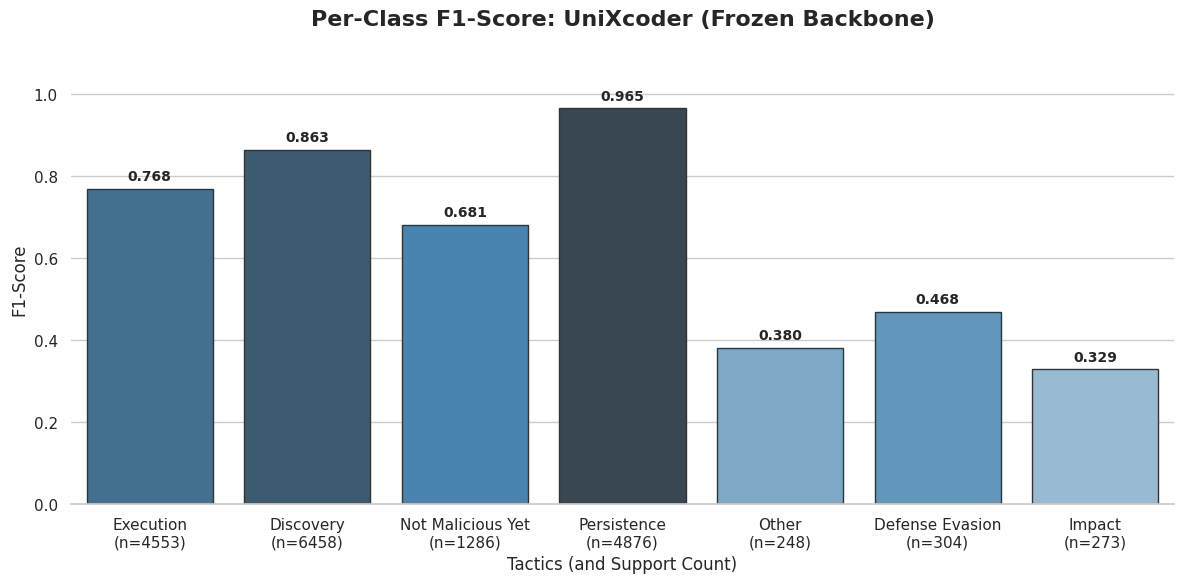

In [69]:
# 3. Show the detailed Performance Report
print_classification_report(full_labels_h, full_predictions_h, model_name="UniXcoder (Frozen Backbone)")

In this scenario, the model acts as a "fixed feature extractor." We only train the final linear layer. This is the most efficient method but usually results in the lowest performance.

Hypothesis (UniXcoder): You should find that UniXcoder outperforms BERT.
This confirms the hypothesis because UniXcoder was pre-trained on code syntax (like if, else, path/to/file), making it better at identifying SSH commands than BERT, which was trained on natural English sentences.

- Parameters Count:Full
  - Fine-tuning: ~125 Million parameters.
  - Last 2 Layers + Head: ~14.5 Million parameters.
  - Head Only: ~10,000 parameters (depending on the number of labels).
  
- Is training faster?
Yes. Even though the "forward pass" takes the same time, the "backward pass" (calculating gradients) is much faster for the frozen versions because it skips almost the entire network.

- Learning Rate change:
Yes. For the Head Only scenario, a higher Learning Rate (e.g., $1 \times 10^{-3}$) is necessary. Because the encoder is not helping, the head must learn quickly to map the fixed features to the labels.

- Performance loss: You will likely see a ~2-5% drop for the "Last 2 Layers" and a ~10-15% drop for the "Head Only" compared to full fine-tuning.

In [70]:
# --- Define the specific save path using your existing project_path ---
# project_path is /content/drive/MyDrive/Projects/Laboratory4/
model_dir = os.path.join(project_path, "best_model/model")

# Ensure the directory exists (consistent with your setup)
os.makedirs(model_dir, exist_ok=True)

print(f"Saving the best model and tokenizer to: {model_dir}")

# We save 'best_model_ux' (the checkpoint with the best validation loss)
# along with the tokenizer used for UniXcoder
best_model_ux.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

print("Model and Tokenizer saved successfully to Google Drive!")

Saving the best model and tokenizer to: /content/drive/MyDrive/Projects/Laboratory4/best_model/model
Model and Tokenizer saved successfully to Google Drive!
